# Proyecto Final - Machine Learning


---


### *Integrantes*:

Luis Cagigal

Luis Astudillo

Sean Kondracki

### *Tema*:
Predicciones basadas en datos de la NBA

    1. Si un equipo va a ganar o no su siguiente partido (clasificación)
    2. El marcador de ese partido (regresión)


## Introducción

En el campo de los deportes existen muchas aplicaciones de la tecnología para mejorar la experiencia de los aficionados. Estas innovaciones tecnológicas operan tanto dentro como fuera de la cancha y manejan grandes cantidades de dinero. Una parte del deporte que más dinero mueve a nivel mundial son las apuestas. Este modelo busca ayudar a los corredores de apuestas a elaborar tasas y predicciones con mayor facilidad, maximizando los beneficios de su negocio. Nuestro modelo utiliza la base de datos de la NBA (E) contieniendo datos de partidos de los últimos 50+ años. La tarea (T) es predecir si un equipo va a ganar o perder su siguiente partido y cuál sería el marcador. El rendimiento (P) del modelo se evaluará de acuerdo a la precisión en cuanto a las predicciones del mismo en base a los resultados ya obtenidos previamente.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# Main dataset = game.csv
game_df = pd.read_csv("drive/MyDrive/game.csv")

# Drop NaN values in dataset
game_df = game_df.dropna()

# We use only games from the last 2 years for relevancy
dataset = game_df.tail(2460)
dataset = dataset.reset_index(drop=True)

# Features
dataset.columns

Index(['season_id', 'team_id_home', 'team_abbreviation_home', 'team_name_home',
       'game_id', 'game_date', 'matchup_home', 'wl_home', 'min', 'fgm_home',
       'fga_home', 'fg_pct_home', 'fg3m_home', 'fg3a_home', 'fg3_pct_home',
       'ftm_home', 'fta_home', 'ft_pct_home', 'oreb_home', 'dreb_home',
       'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home', 'pf_home',
       'pts_home', 'plus_minus_home', 'video_available_home', 'team_id_away',
       'team_abbreviation_away', 'team_name_away', 'matchup_away', 'wl_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'pts_away', 'plus_minus_away', 'video_available_away'],
      dtype='object')

In [ ]:
# Feature Selection

# Feature Selection

#Eliminamos informacion incompleta

dataset = dataset.dropna().reset_index(drop=True) #Drop = true, utilizamos loc de Pandas,
#lo que asegura que estamos trabajando con el DataFrame original en lugar de una vista


#Informacion repetida
dataset = dataset.drop_duplicates().reset_index(drop=True)

#Columnas sin informacion relevante, etiquetas, fechas, variables con redundancia, etc.
#De igual manera eliminamos los valores

dataset = dataset.drop(['season_id','team_id_home','team_name_home','game_id','game_date',
                        'matchup_home','min','video_available_home','team_id_away','team_name_away',
                        'matchup_away','video_available_away', 'wl_away', 'plus_minus_home', 'plus_minus_away'], axis=1)



In [ ]:
unique_team_abbreviation_away = dataset['team_abbreviation_away'].unique()
unique_team_abbreviation_home = dataset['team_abbreviation_home'].unique()

In [ ]:
#One-hot encoding: forma de representar variables categóricas como un vector binario

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder


class FeatureEncoder(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    encoder = OneHotEncoder()

    matrix = encoder.fit_transform(X[['team_abbreviation_home']]).toarray()
    for i in range(len(matrix.T)):
      X[unique_team_abbreviation_home[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['team_abbreviation_away']]).toarray()
    for i in range(len(matrix.T)):
      X[unique_team_abbreviation_away[i]] = matrix.T[i]

    X_encoded = X.drop(['team_abbreviation_home', 'team_abbreviation_away'], axis=1)
    return X_encoded

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, target, threshold=1.7):
        self.target = target
        self.threshold = str(threshold) + "*mean"   # umbral de selección de características

    def fit(self, X, y=None):
        self.model = RandomForestClassifier(n_estimators=100)
        if isinstance(y, pd.DataFrame) and self.target in y.columns:
            self.model.fit(X, y[self.target])     # columna objetivo y[target]
        else:
            raise ValueError(f"Target column {self.target} not found in y")

        self.selector = SelectFromModel(self.model, prefit=True, threshold=self.threshold)
        return self

    def transform(self, X):
        X_selected = self.selector.transform(X)  # Selección de características para seleccionar un subconjunto de características de X
        selected_feature_indices = self.selector.get_support(indices=True)
        selected_feature_names = X.columns[selected_feature_indices]
        X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)  # Crea un DataFrame con las características seleccionadas y sus nombres
        return X_selected_df

In [ ]:
# Classification dataset
X_fs = dataset.drop(['wl_home','pts_home','pts_away'], axis=1)
Y_wl = dataset[['wl_home']]
# Points prediction

Y_cut = pd.DataFrame(Y_wl['wl_home'].map({'W': 1, 'L': 0}))
Y_cut.head()

Y_pts = dataset[['pts_home']]

In [ ]:
# Split dataset into training, test, and validation for W/L prediction
from sklearn.model_selection import train_test_split

# 0.60 -> Train
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y_cut, test_size = 0.2, random_state=127, stratify=Y_cut) # 0.20 -> Test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=127, stratify=y_train) # 0.25 * 0.80 = 0.20 -> Val

# Training sample size
print(X_train.shape)

# Testing sample size
print(X_test.shape)

# Validation sample size
print(X_val.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

encoder = FeatureEncoder()

# Apply encoding to the training data
X_train_encoded = encoder.fit_transform(X_train)

# Apply encoding to the test data
X_test_encoded = encoder.transform(X_test)

# Create a FeatureDropper for each target
dropper_wl_home = FeatureDropper('wl_home')

# Fit and transform X for each target
X_wl_home = dropper_wl_home.fit_transform(X_train_encoded, y_train)

X_wl_home.info()

In [ ]:
# Feature Selection Final
features = ['fg_pct_home', 'fg3_pct_home', 'dreb_home', 'reb_home',
       'ast_home', 'fg_pct_away',  'fg3_pct_away',
       'dreb_away', 'reb_away', 'ast_away']



print("Features size:", len(features))

Features size: 10


In [ ]:
# Classification dataset
X_fs = dataset[features]
Y_wl = dataset[['wl_home']]
# Points prediction
Y_pts = dataset[['pts_home']]
Y_pts2 = dataset[['pts_away']]

# Initial shapes
print(X_fs.shape)
print(Y_wl.shape)
print(Y_pts.shape)

(2460, 10)
(2460, 1)
(2460, 1)


In [ ]:
# Mapped values from W into 1, L into 0
Y_cut = pd.DataFrame(Y_wl['wl_home'].map({'W': 1, 'L': 0}))
Y_cut.head()

,wl_home
0,0
1,1
2,0
3,1
4,1


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2460 samples in 0.005s...
[t-SNE] Computed neighbors for 2460 samples in 0.227s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2460
[t-SNE] Computed conditional probabilities for sample 2000 / 2460
[t-SNE] Computed conditional probabilities for sample 2460 / 2460
[t-SNE] Mean sigma: 3.174347
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.521530
[t-SNE] KL divergence after 1000 iterations: 1.572027


[Text(0.5, 1.0, 'T-SNE projection')]

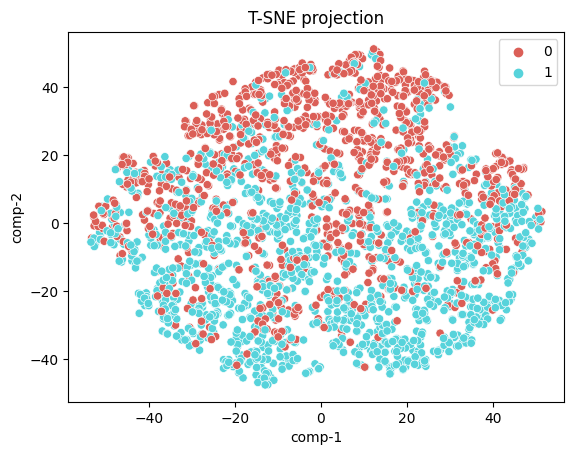

In [ ]:
# Visualization with TSNE for W/L prediction
from sklearn.manifold import TSNE
import seaborn as sns

# TSNE visualization for filtered dataset with feature selection
tsne = TSNE(n_components=2, verbose=1, random_state=127)
z = tsne.fit_transform(X_fs)

# TSNE features
v_df = pd.DataFrame()
v_df["y"] = Y_cut
v_df["comp-1"] = z[:,0]
v_df["comp-2"] = z[:,1]

# Plot
sns.scatterplot(x="comp-1", y="comp-2", hue=v_df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=v_df).set(title="T-SNE projection")

In [ ]:
# Split dataset into training, test, and validation for W/L prediction
from sklearn.model_selection import train_test_split

# 0.60 -> Train
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y_cut, test_size = 0.2, random_state=127, stratify=Y_cut) # 0.20 -> Test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=127, stratify=y_train) # 0.25 * 0.80 = 0.20 -> Val

# Training sample size
print(X_train.shape)

# Testing sample size
print(X_test.shape)

# Validation sample size
print(X_val.shape)

(1476, 10)
(492, 10)
(492, 10)


In [ ]:
# Search for invalid rows in dataset
invalid_rows = y_train.loc[~y_train['wl_home'].isin([0, 1])]

# Print the invalid rows
print(invalid_rows)

Empty DataFrame
Columns: [wl_home]
Index: []


In [ ]:
# Imports for Logistic Regression (Classification) model (W/L prediction)
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Optimize model hyperparameters with GridSearchCV

# Regression pipeline
classifier = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scal', StandardScaler()),
    ('reg', LogisticRegression())
])

# Repeated KFold CV for hyperparameter optimization
rkf = RepeatedKFold(n_splits=5, random_state=150)

# Parameter grid
penalty = ['l2']
poly_feats = list(range(1,3))
C_values = [10000, 1000, 100, 10, 1, 0.1]

parameters = dict(poly__degree=poly_feats, reg__C=C_values, reg__penalty=penalty, reg__max_iter=[10000])

# GridSearchCV to search for optimized hyperparameters
search = GridSearchCV(estimator=classifier, param_grid=parameters, cv=rkf, scoring='neg_mean_squared_error', n_jobs=-1)

# Results for model
result = search.fit(X_val, y_val)

# Print scores
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.17417851989280564
Best Hyperparameters: {'poly__degree': 2, 'reg__C': 0.1, 'reg__max_iter': 10000, 'reg__penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Model with optimized hyperparameters
poly_deg = 2
C_val = 0.1

# Optimized classifier
classifier_opt = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_deg)),
    ('scal', StandardScaler()),
    ('reg', LogisticRegression(penalty='l2', C=C_val, max_iter=10000))
])

In [ ]:
# Training
classifier_opt.fit(X_train, y_train)

# Accuracy for training set
train_accuracy = classifier_opt.score(X_train,y_train)
print("Training accuracy:", train_accuracy)

# Accuracy for testing set
test_accuracy = classifier_opt.score(X_test,y_test)
print("Testing accuracy:", test_accuracy)

Training accuracy: 0.8584010840108401
Testing accuracy: 0.8373983739837398


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


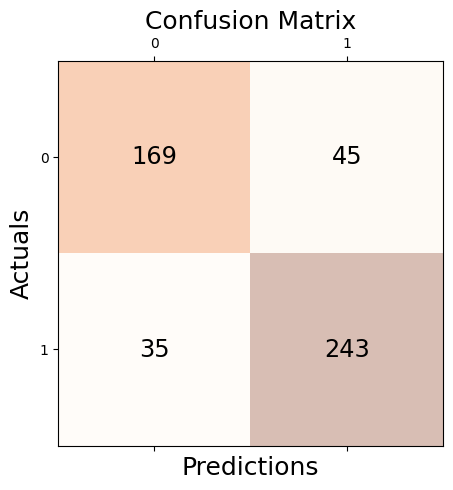

In [ ]:
# F1-score calculation

# Predictions
y_pred = classifier_opt.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Confusion matrix plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# Precision score
print('Precision: %.3f' % precision_score(y_test, y_pred))

# Recall score
print('Recall: %.3f' % recall_score(y_test, y_pred))

# F1-score value
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Precision: 0.844
Recall: 0.874
F1 Score: 0.859


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2460 samples in 0.005s...
[t-SNE] Computed neighbors for 2460 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2460
[t-SNE] Computed conditional probabilities for sample 2000 / 2460
[t-SNE] Computed conditional probabilities for sample 2460 / 2460
[t-SNE] Mean sigma: 3.174347
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.521530
[t-SNE] KL divergence after 1000 iterations: 1.572027


[]

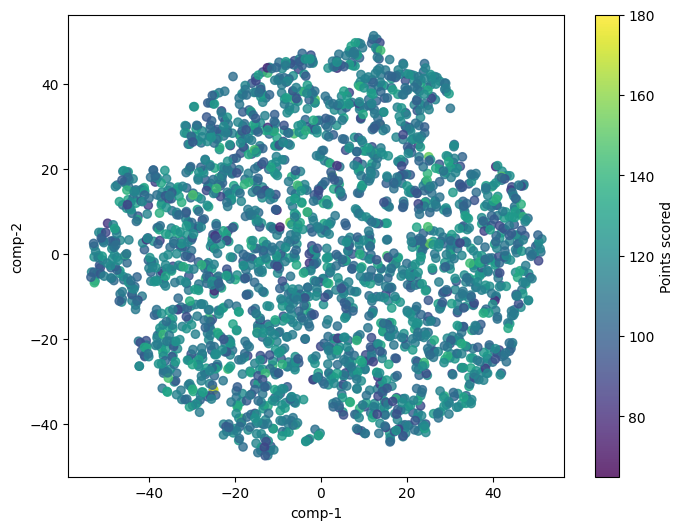

In [ ]:
# Visualization with TSNE for points prediction
tsne = TSNE(n_components=2, verbose=1, random_state=127)
z = tsne.fit_transform(X_fs) #TODO

# TSNE features
v_df = pd.DataFrame()
v_df["y"] = dataset['pts_home']
v_df["comp-1"] = z[:,0]
v_df["comp-2"] = z[:,1]

y_sample = v_df['y'].sample(n=2460, random_state=127)
c_map = np.array(y_sample)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(v_df['comp-1'], v_df['comp-2'], c=c_map, vmin=65, vmax=180, cmap='viridis', alpha=0.8)
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.colorbar().set_label("Points scored")
plt.plot()



In [ ]:
# Split dataset into training, test, and validation for points scored prediction

# 0.60 -> Train
X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(X_fs, Y_pts, test_size = 0.2, random_state=251) # 0.20 -> Test
X_train_pts, X_val_pts, y_train_pts, y_val_pts = train_test_split(X_train_pts, y_train_pts, test_size = 0.25, random_state=301) # 0.25 * 0.80 = 0.20 -> Val

# Training sample size
print(X_train_pts.shape)

# Testing sample size
print(X_test_pts.shape)

# Validation sample size
print(X_val_pts.shape)

(1476, 10)
(492, 10)
(492, 10)


In [ ]:
# Imports for Linear Regression (Regression) model (Points scored prediction)
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Optimize model hyperparameters with GridSearchCV

# Regresser pipeline
regresser = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scal', StandardScaler()),
    ('reg', ElasticNet())
])

# Repeated KFold CV for hyperparameter optimization
rkf_pts = RepeatedKFold(n_splits=5, random_state=181)

# Parameter grid
poly_deg_pts = [1, 2]
alpha_val = [0.001, 0.01, 0.1, 1]
l1_val = [0.25, 0.5, 0.75, 0.80]

parameters_pts = dict(poly__degree=poly_deg_pts, reg__alpha=alpha_val, reg__l1_ratio=l1_val)

# GridSearchCV to search for optimized hyperparameters
search_pts = GridSearchCV(estimator=regresser, param_grid=parameters_pts, cv=rkf_pts, scoring='neg_mean_squared_error', n_jobs=-1, refit=True)

# Results for model
result_pts = search_pts.fit(X_val_pts, y_val_pts)

# Print scores
print('Best Score: %s' % result_pts.best_score_)
print('Best Hyperparameters: %s' % result_pts.best_params_)

Best Score: -41.13188748187593
Best Hyperparameters: {'poly__degree': 2, 'reg__alpha': 0.01, 'reg__l1_ratio': 0.25}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.975e+03, tolerance: 7.171e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Model with optimized hyperparameters
poly_deg_pts = 2
alpha_pts = 0.1
l1_pts = 0.25

# Optimized regresser
regresser = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_deg_pts)),
    ('scal', StandardScaler()),
    ('reg', ElasticNet(alpha=alpha_pts, l1_ratio=l1_pts))
])

In [ ]:
# Training
regresser.fit(X_train_pts, y_train_pts)

# Accuracy for training set
train_accuracy_pts = regresser.score(X_train_pts,y_train_pts)
print("Training accuracy:", train_accuracy_pts)

# Accuracy for testing set
test_accuracy_pts = regresser.score(X_test_pts,y_test_pts)
print("Testing accuracy:", test_accuracy_pts)

Training accuracy: 0.7449114157806533
Testing accuracy: 0.7646498590667685


In [ ]:
y_train_pts_pred = regresser.predict(X_train_pts)
y_test_pts_pred = regresser.predict(X_test_pts)

# Change
metrics = {
    'mean_squared_error': mean_squared_error(y_train_pts, y_train_pts_pred),
    'root_mean_squared_error': mean_squared_error(y_train_pts, y_train_pts_pred, squared=False),
    'r_square':  r2_score(y_train_pts, y_train_pts_pred)
}
metrics = pd.Series(metrics)
print(metrics)

mean_squared_error         39.154174
root_mean_squared_error     6.257330
r_square                    0.744911
dtype: float64


## Puntos Visitante

In [ ]:
# Split dataset into training, test, and validation for points scored prediction

# 0.60 -> Train
X_train_pts, X_test_pts, y_train_pts, y_test_pts = train_test_split(X_fs, Y_pts2, test_size = 0.2, random_state=251) # 0.20 -> Test
X_train_pts, X_val_pts, y_train_pts, y_val_pts = train_test_split(X_train_pts, y_train_pts, test_size = 0.25, random_state=301) # 0.25 * 0.80 = 0.20 -> Val

# Training sample size
print(X_train_pts.shape)

# Testing sample size
print(X_test_pts.shape)

# Validation sample size
print(X_val_pts.shape)

(1476, 10)
(492, 10)
(492, 10)


In [ ]:
# Model with optimized hyperparameters
poly_deg_pts = 2
alpha_pts = 0.1
l1_pts = 0.25

# Optimized regresser
regresser2 = Pipeline([
    ('poly', PolynomialFeatures(degree=poly_deg_pts)),
    ('scal', StandardScaler()),
    ('reg', ElasticNet(alpha=alpha_pts, l1_ratio=l1_pts))
])

In [ ]:
# Training
regresser2.fit(X_train_pts, y_train_pts)

# Accuracy for training set
train_accuracy_pts = regresser2.score(X_train_pts,y_train_pts)
print("Training accuracy:", train_accuracy_pts)

# Accuracy for testing set
test_accuracy_pts = regresser2.score(X_test_pts,y_test_pts)
print("Testing accuracy:", test_accuracy_pts)

Training accuracy: 0.7515645598900743
Testing accuracy: 0.7414780342204569


In [ ]:
y_train_pts_pred = regresser2.predict(X_train_pts)
y_test_pts_pred = regresser2.predict(X_test_pts)

# Change
metrics = {
    'mean_squared_error': mean_squared_error(y_train_pts, y_train_pts_pred),
    'root_mean_squared_error': mean_squared_error(y_train_pts, y_train_pts_pred, squared=False),
    'r_square':  r2_score(y_train_pts, y_train_pts_pred)
}
metrics = pd.Series(metrics)
print(metrics)

mean_squared_error         39.175230
root_mean_squared_error     6.259012
r_square                    0.751565
dtype: float64


## Neural Networks

In [ ]:
# Neural Networks imports
import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping

In [ ]:
# Create a neural network function
def create_nn(hidden_layers, neurons, reg):
    regularizer = keras.regularizers.L1L2(l1=reg, l2=reg)
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = (10)))
    for layer in range(hidden_layers):
        model.add(keras.layers.Dense(units=neurons, activation='relu', kernel_regularizer=regularizer))
    model.add(keras.layers.Dense(units= 1, kernel_regularizer=regularizer))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Neural net optimization
es = EarlyStopping(monitor='loss', patience=3)
nn_classifier = KerasClassifier(model=create_nn, epochs=50, batch_size=5, callbacks=[es])

pipeline_nn = Pipeline([
    ('sca', StandardScaler()),
    ('nn', nn_classifier)
])

# Repeated KFold CV for hyperparameter optimization
rkf_nn = RepeatedKFold(n_splits=2, random_state=142)

# Parameter grid
n_hidden = [1]
neuron_val = [10, 15]
reg_val = [0.01, 0.1]

parameters_nn = dict(nn__model__hidden_layers=n_hidden, nn__model__neurons=neuron_val, nn__model__reg=reg_val)

# GridSearchCV to search for optimized hyperparameters
search_nn = GridSearchCV(estimator=pipeline_nn, param_grid=parameters_nn, cv=rkf_nn, scoring='neg_mean_squared_error')

# Results for model
result_nn = search_nn.fit(X_val, y_val)

# Print scores
print('Best Score: %s' % result_nn.best_score_)
print('Best Hyperparameters: %s' % result_nn.best_params_)

Se han truncado las últimas 5000 líneas del flujo de salida.
50/50 [==============================] - 0s 3ms/step - loss: 1.4314 - accuracy: 0.8455
Epoch 44/50
50/50 [==============================] - 0s 2ms/step - loss: 1.3929 - accuracy: 0.8374
Epoch 45/50
50/50 [==============================] - 0s 3ms/step - loss: 1.3557 - accuracy: 0.8374
Epoch 46/50
50/50 [==============================] - 0s 3ms/step - loss: 1.3194 - accuracy: 0.8455
Epoch 47/50
50/50 [==============================] - 0s 3ms/step - loss: 1.2831 - accuracy: 0.8496
Epoch 48/50
50/50 [==============================] - 0s 3ms/step - loss: 1.2472 - accuracy: 0.8455
Epoch 49/50
50/50 [==============================] - 0s 3ms/step - loss: 1.2124 - accuracy: 0.8415
Epoch 50/50
50/50 [==============================] - 0s 3ms/step
Epoch 1/50
50/50 [==============================] - 1s 3ms/step - loss: 5.2440 - accuracy: 0.7236
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 4.6822 - accuracy: 0.72

In [ ]:
# Optimized neural net
model = create_nn(1, 15, 0.1)

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

Epoch 1/100
148/148 [==============================] - 2s 4ms/step - loss: 179.4314 - accuracy: 0.3421
Epoch 2/100
148/148 [==============================] - 0s 3ms/step - loss: 49.0668 - accuracy: 0.3394
Epoch 3/100
148/148 [==============================] - 0s 3ms/step - loss: 39.1500 - accuracy: 0.3496
Epoch 4/100
148/148 [==============================] - 0s 3ms/step - loss: 28.7621 - accuracy: 0.3591
Epoch 5/100
148/148 [==============================] - 1s 4ms/step - loss: 15.6365 - accuracy: 0.4051
Epoch 6/100
148/148 [==============================] - 0s 3ms/step - loss: 8.0457 - accuracy: 0.4688
Epoch 7/100
148/148 [==============================] - 0s 3ms/step - loss: 5.7228 - accuracy: 0.5244
Epoch 8/100
148/148 [==============================] - 0s 3ms/step - loss: 4.8473 - accuracy: 0.5386
Epoch 9/100
148/148 [==============================] - 0s 3ms/step - loss: 4.3093 - accuracy: 0.5535
Epoch 10/100
148/148 [==============================] - 0s 3ms/step - loss: 3.9160 - 

In [ ]:
y_pred = model.predict(X_test)

# Threshold
threshold = 0.5

# Convert probabilities into class labels
y_pred_class = (y_pred >= threshold).astype(int)

# Now compute the metrics
print('Precision: %.3f' % precision_score(y_test, y_pred_class))
print('Recall: %.3f' % recall_score(y_test, y_pred_class))
print('F1 Score: %.3f' % f1_score(y_test, y_pred_class))

16/16 [==============================] - 0s 2ms/step
Precision: 0.734
Recall: 0.881
F1 Score: 0.801


In [ ]:
# RepeatedStratifiedKFold CV for hypothesis test
rkf2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=115)

# CV Scores (8 min de exec time)
LR_cv = - cross_val_score(search, X=X_val, y=y_val, cv=rkf2, n_jobs=-1)
print(LR_cv)

[0.19191919 0.12121212 0.24489796 0.19387755 0.13265306 0.18181818
 0.24242424 0.16326531 0.12244898 0.17346939]


In [ ]:
# RepeatedStratifiedKFold CV for hypothesis test
rkf2_nn = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=115)

# CV Scores (14 min de exec time)
NN_cv = - cross_val_score(search_nn, X=X_val, y=y_val, cv=rkf2_nn, n_jobs=-1)
print(NN_cv)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[0.2020202  0.17171717 0.2755102  0.2244898  0.16326531 0.17171717
 0.21212121 0.24489796 0.14285714 0.29591837]


In [ ]:
from scipy.stats import wilcoxon

htest = wilcoxon(LR_cv, NN_cv, alternative='less')

print("Stat: " + str(htest.statistic) + "\nPVal: " + str(htest.pvalue))

Stat: 5.5
PVal: 0.009765625


El p-value obtenido en el análisis fue de 0.009, lo que indica que es menor que el nivel de significancia establecido (alpha), lo que sugiere que existe evidencia estadística que respalda la hipótesis de que el modelo de regresión logística es superior al modelo de red neuronal.

# Conclusiones

Durante el proceso de preprocesamiento de datos se enfrentaron diversas dificultades. A pesar de haber realizado la selección de características, se encontró que aún existían variables que provocaron que el sistema presentara un accuracy del 100%, ya que estas variables permitían un mapeo preciso del resultado. Para solucionar este problema, fue necesario realizar una eliminación manual de dichas variables después de completar el preprocesamiento.

Además, se utilizó el clasificador RandomForestClassifier, el cual facilitó la selección de características mediante el uso de un umbral "n". En general, se pudo observar la importancia de llevar a cabo un adecuado proceso de preprocesamiento de datos para evitar la inclusión de variables irrelevantes o redundantes que puedan afectar negativamente el rendimiento del modelo predictivo.

Se logró formular dos modelos adaptados a las necesidades de nuestra problemática, siendo las regresiones lineales y logísticas, y las redes neuronales. Se optimizaron los parámetros de cada modelo utilizando GridSearchCV, resultando en la prueba de hipótesis. La prueba devolvió un valor de p = 0.009 < alpha = 0.5, demostrando una mejora estadística entre ambos modelos.

Predecir resultados en el ámbito deportivo es sumamente complicado, sin embargo, hemos concluido que se pueden desarrollar modelos robustos complejos que puedan contribuir con el mercado de apuestas de manera positiva, produciendo resultados acordes al contexto planteado.

In [ ]:
matches = {
    'MIA-NYK': [[0.46, 0.344, 30.9, 40.6, 23.8, 0.47, 0.354, 34, 46.6, 22.9]],
    'GSW-LAL': [[0.479, 0.385, 34.1, 44.6, 29.8, 0.482, 0.346, 35.7, 45.7, 25.3]]
}



print(classifier_opt.predict(matches['MIA-NYK']))
print(regresser.predict(matches['MIA-NYK']))
print(regresser2.predict(matches['MIA-NYK']))
print(classifier_opt.predict(matches['GSW-LAL']))
print(regresser.predict(matches['GSW-LAL']))
print(regresser2.predict(matches['GSW-LAL']))

[0]
[109.64138576]
[112.20411597]
[1]
[119.29978379]
[115.86826696]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

## Referencias


[1] "Feature selection using SelectFromModel," scikit-learn, [Online]. Available: https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel.

[2] A. Hegde, "Scikit-learn Pipeline Tutorial with Parameter Tuning and Cross-Validation," Towards Data Science, [Online]. Available: https://towardsdatascience.comscikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb.

[3] F. Pedregosa et al., "Scikit-learn: Machine Learning in Python," Journal of Machine Learning Research, vol. 12, pp. 2825-2830, Oct. 2011.

[4] G. Louppe, "Understanding Random Forests: From Theory to Practice," PhD Thesis, Université de Liège, Belgium, 2014. [Online]. Available: https://orbi.uliege.be/bitstream/2268/170309/1/thesis.pdf.

[5] J. Brownlee, "How to Use Keras Deep Learning Models with Scikit-Learn in Python," Machine Learning Mastery, [Online]. Available: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/.

[6] L. Breiman, "Random Forests," Machine Learning, vol. 45, no. 1, pp. 5-32, Oct. 2001, doi: 10.1023/A:1010933404324.

[7] M. Waskom, "Seaborn: Statistical Data Visualization," Journal of Open Source Software, vol. 6, no. 60, p. 3021, Nov. 2021, doi: 10.21105/joss.03021.

[8] P. K., "Micro-average & Macro-average Scoring Metrics for Multi-class Classification in Python," Vitalflux, [Online]. Available: https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/.


[9] "scipy.stats.wilcoxon," SciPy v1.7.1 Reference Guide, [Online]. Available: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy-stats-wilcoxon.

[10] "sklearn.model_selection.RepeatedStratifiedKFold," scikit-learn, [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold.

